#                       Zee Recommender System

In [90]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix


In [91]:
m = pd.read_fwf('data/zee-movies.dat')
r = pd.read_fwf('data/zee-ratings.dat')
u = pd.read_fwf('data/zee-users.dat')

In [92]:
m.head()

,Movie ID::Title::Genres,Unnamed: 1,Unnamed: 2
0,1::Toy Story (1995)::Animation|Children's|Comedy,NaN,NaN
1,2::Jumanji (1995)::Adventure|Children's|Fantasy,NaN,NaN
2,3::Grumpier Old Men (1995)::Comedy|Romance,NaN,NaN
3,4::Waiting to Exhale (1995)::Comedy|Drama,NaN,NaN
4,5::Father of the Bride Part II (1995)::Comedy,NaN,NaN


In [93]:
movies=m.drop(columns=['Unnamed: 1','Unnamed: 2'])

In [94]:
movies.head()

,Movie ID::Title::Genres
0,1::Toy Story (1995)::Animation|Children's|Comedy
1,2::Jumanji (1995)::Adventure|Children's|Fantasy
2,3::Grumpier Old Men (1995)::Comedy|Romance
3,4::Waiting to Exhale (1995)::Comedy|Drama
4,5::Father of the Bride Part II (1995)::Comedy


In [95]:
movies=movies['Movie ID::Title::Genres'].str.split('::',expand=True)
movies.columns=['MovieID','Title','Genres']

In [96]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [97]:
def findYear(x):
    if('19' in x):
        a=x.index('19')
        return int(x[a:a+4])
    elif('20' in x):
        a=x.index('20')
        return int(x[a:a+4])
    else:
        return 0

In [98]:
def Title(x):
    if('19' in x or '20' in x):
        return x[:-7]
    else:
        return x

In [99]:
movies['Year'] = movies['Title'].apply(lambda x:findYear(x))
movies['Title'] = movies['Title'].apply(lambda x:Title(x))


In [100]:
movies.head(5)

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [101]:
movies['Title']

0                         Toy Story
1                           Jumanji
2                  Grumpier Old Men
3                 Waiting to Exhale
4       Father of the Bride Part II
                   ...             
3878               Meet the Parents
3879            Requiem for a Dream
3880                      Tigerland
3881               Two Family House
3882                 Contender, The
Name: Title, Length: 3883, dtype: object

In [102]:
movies.loc[movies['Title'].str.contains('Outlaw, The')]

,MovieID,Title,Genres,Year
955,967,"Outlaw, The",Western,1943


In [103]:
movies.shape

(3883, 4)

<b> There are 3883 movies in the dataset </b>

In [104]:
movies['Year'].unique()

array([1995, 1994, 1996,    0, 1976, 1993, 1992, 1988, 1967, 1964, 1977,
       1965, 1982, 1962, 1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973,
       1970, 1960, 1955, 1956, 1959, 1968, 1980, 1975, 1986, 1948, 1943,
       1950, 1946, 1987, 1997, 1974, 1958, 1949, 1972, 1998, 1933, 1952,
       1951, 1957, 1961, 1954, 1934, 1944, 1963, 1942, 1941, 1953, 1939,
       1947, 1945, 1938, 1935, 1936, 1926, 1932, 1930, 1971, 1979, 1966,
       1978, 1985, 1983, 1984, 1931, 1922,   19, 1927, 1929,  195, 1928,
       1925, 1923, 1999, 1900, 1919, 2000, 1920, 1921], dtype=int64)

In [105]:
mode_year=movies['Year'].mode()
movies.replace({'Year':{
    0 : mode_year,
    19: mode_year,
    195 : mode_year
}},
    inplace=True          )

In [106]:
movies['Year'].unique()

array([1995, 1994, 1996, 1976, 1993, 1992, 1988, 1967, 1964, 1977, 1965,
       1982, 1962, 1990, 1991, 1989, 1937, 1940, 1969, 1981, 1973, 1970,
       1960, 1955, 1956, 1959, 1968, 1980, 1975, 1986, 1948, 1943, 1950,
       1946, 1987, 1997, 1974, 1958, 1949, 1972, 1998, 1933, 1952, 1951,
       1957, 1961, 1954, 1934, 1944, 1963, 1942, 1941, 1953, 1939, 1947,
       1945, 1938, 1935, 1936, 1926, 1932, 1930, 1971, 1979, 1966, 1978,
       1985, 1983, 1984, 1931, 1922, 1927, 1929, 1928, 1925, 1923, 1999,
       1900, 1919, 2000, 1920, 1921], dtype=int64)

In [107]:
max(movies['Year']) - min(movies['Year'])

100

<b>These movies belongs to 19th Century </b>

In [108]:
r.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [109]:
ratings=r
ratings.head()

,UserID::MovieID::Rating::Timestamp
0,1::1193::5::978300760
1,1::661::3::978302109
2,1::914::3::978301968
3,1::3408::4::978300275
4,1::2355::5::978824291


In [110]:
ratings=ratings['UserID::MovieID::Rating::Timestamp'].str.split('::',expand=True)
ratings.columns=['UserID','MovieID','Rating','Timestamp']
ratings.sample(5)

,UserID,MovieID,Rating,Timestamp
518422,3200,1653,4,968629872
494263,3032,2355,5,970345633
34568,235,1500,5,976770421
324177,1921,455,3,974693607
435841,2664,2145,3,973455388


In [111]:
ratings.shape

(1000209, 4)

The data has total 1000209 reatings

## Basic EDA on data

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of movies by Rating')

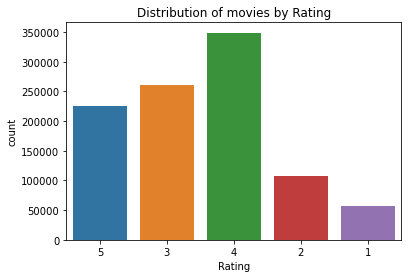

In [112]:
sns.countplot('Rating',data=ratings)
plt.title('Distribution of movies by Rating')

<b>Most of the times users has rated the movies as '4'</b>

In [113]:
def decade(x):
    if(x<2000):
        return str((((x)%1900)//10)*10)+'s'
    else:
        return "2000s"
movies['Decade'] = movies['Year'].apply(lambda x:decade(x))

In [114]:
movies.head()

,MovieID,Title,Genres,Year,Decade
0,1,Toy Story,Animation|Children's|Comedy,1995,90s
1,2,Jumanji,Adventure|Children's|Fantasy,1995,90s
2,3,Grumpier Old Men,Comedy|Romance,1995,90s
3,4,Waiting to Exhale,Comedy|Drama,1995,90s
4,5,Father of the Bride Part II,Comedy,1995,90s


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of movies by Release Year/ Decade')

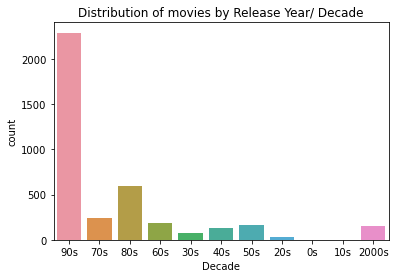

In [115]:
sns.countplot('Decade',data=movies)
plt.title('Distribution of movies by Release Year/ Decade')

<b>Most of the movies are from 90's</b>

In [116]:
users=u
u.sample(5)

,UserID::Gender::Age::Occupation::Zip-code
1014,1015::M::35::3::11220
5682,5683::F::18::9::94538
2926,2927::M::25::12::24060
5144,5145::M::35::7::77565-2332
1270,1271::F::45::6::54401


In [117]:
users=users['UserID::Gender::Age::Occupation::Zip-code'].str.split('::',expand=True)
users.columns=['UserID','Gender','Age','Occupation','ZipCode']
users.sample(5)

,UserID,Gender,Age,Occupation,ZipCode
1950,1951,F,18,4,90630
3445,3446,M,25,7,30620
423,424,M,25,17,55112
623,624,M,25,1,75207
4219,4220,M,35,0,97225


In [118]:
users['Age'].unique()

array(['1', '56', '25', '45', '50', '35', '18'], dtype=object)

In [119]:
users.replace({'Age':{ '1' : 'Under 18','18': "18-24",

'25': "25-34",

'35': "35-44",

'45': "45-49",

'50': "50-55",

'56': "56+"}},inplace=True)

In [120]:
users.replace({'Occupation' : {'0': "other",

'1': "academic/educator",

'2': "artist",

'3': "clerical/admin",

'4': "college/grad student",

'5': "customer service",

'6': "doctor/health care",

'7': "executive/managerial",

'8': "farmer",

'9': "homemaker",

'10': "K-12 student",

'11': "lawyer",

'12': "programmer",

'13': "retired",

'14': "sales/marketing",

'15': "scientist",

'16': "self-employed",

'17': "technician/engineer",

'18': "tradesman/craftsman",

'19': "unemployed",

'20': "writer"}},inplace=True)

In [121]:
users.sample(10)

,UserID,Gender,Age,Occupation,ZipCode
3068,3069,M,18-24,college/grad student,97470
3616,3617,M,35-44,executive/managerial,49034
5442,5443,M,25-34,programmer,01915
3263,3264,F,25-34,academic/educator,94536
1148,1149,M,25-34,programmer,98103
5877,5878,F,25-34,other,60640
90,91,M,35-44,executive/managerial,07650
1747,1748,M,50-55,academic/educator,04240
5346,5347,M,25-34,doctor/health care,53705
839,840,F,25-34,clerical/admin,02828


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of users by Gender')

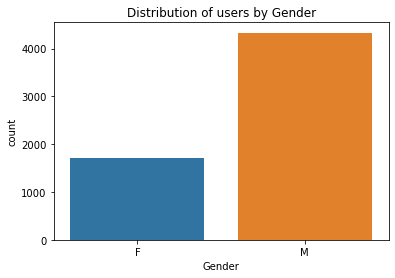

In [122]:
sns.countplot('Gender',data=users)
plt.title('Distribution of users by Gender')

<b>most users are male</b>

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of users by Age')

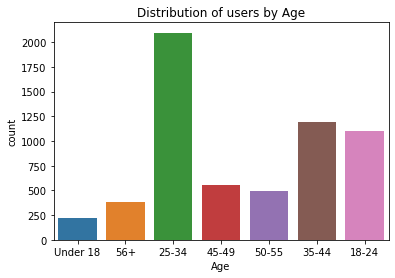

In [123]:
sns.countplot('Age',data=users)
plt.title('Distribution of users by Age')

<b>Most users belongs to age group of 25-34</b>

Text(0.5, 1.0, 'Distribution of users by Occupation')

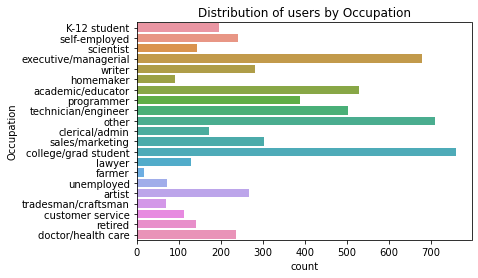

In [124]:
sns.countplot(y='Occupation',data=users,orient="h")
plt.title('Distribution of users by Occupation')

<b>Most number of users are college/ grad student</b>

## Merging the datasets

In [125]:
df1= pd.merge(movies,ratings,how='inner',on='MovieID')
df1.head(10)

,MovieID,Title,Genres,Year,Decade,UserID,Rating,Timestamp
0,1,Toy Story,Animation|Children's|Comedy,1995,90s,1,5,978824268
1,1,Toy Story,Animation|Children's|Comedy,1995,90s,6,4,978237008
2,1,Toy Story,Animation|Children's|Comedy,1995,90s,8,4,978233496
3,1,Toy Story,Animation|Children's|Comedy,1995,90s,9,5,978225952
4,1,Toy Story,Animation|Children's|Comedy,1995,90s,10,5,978226474
5,1,Toy Story,Animation|Children's|Comedy,1995,90s,18,4,978154768
6,1,Toy Story,Animation|Children's|Comedy,1995,90s,19,5,978555994
7,1,Toy Story,Animation|Children's|Comedy,1995,90s,21,3,978139347
8,1,Toy Story,Animation|Children's|Comedy,1995,90s,23,4,978463614
9,1,Toy Story,Animation|Children's|Comedy,1995,90s,26,3,978130703


In [126]:
dff = pd.merge(df1,users,how='inner',on='UserID')
dff.sample(20)

,MovieID,Title,Genres,Year,Decade,UserID,Rating,Timestamp,Gender,Age,Occupation,ZipCode
792179,2243,Broadcast News,Comedy|Drama|Romance,1987,80s,3981,3,965628790,F,45-49,other,97701
625768,1676,Starship Troopers,Action|Adventure|Sci-Fi|War,1997,90s,5443,3,959980433,M,25-34,programmer,01915
71197,2283,"Sheltering Sky, The",Drama,1990,90s,795,2,1038693269,F,35-44,sales/marketing,19147
192639,2901,Phantasm,Horror|Sci-Fi,1979,70s,1922,2,974694424,F,25-34,executive/managerial,94303
183114,491,"Man Without a Face, The",Drama,1993,90s,1861,3,974705011,M,50-55,self-employed,92129
704093,2757,Frances,Drama,1982,80s,2129,5,983416717,M,25-34,customer service,04103
337541,1597,Conspiracy Theory,Action|Mystery|Romance|Thriller,1997,90s,3562,3,966792152,F,25-34,doctor/health care,32812
162918,2407,Cocoon,Comedy|Sci-Fi,1985,80s,1671,4,1018225606,M,35-44,other,98368
939842,2133,Adventures in Babysitting,Adventure|Comedy,1987,80s,4688,4,963619416,M,25-34,homemaker,44310
345264,555,True Romance,Action|Crime|Romance,1993,90s,3626,3,966608497,M,25-34,technician/engineer,75075


In [127]:
dff.tail(50)

,MovieID,Title,Genres,Year,Decade,UserID,Rating,Timestamp,Gender,Age,Occupation,ZipCode
1000159,2028,Saving Private Ryan,Action|Drama|War,1998,90s,5727,4,958489789,M,25-34,college/grad student,92843
1000160,2306,Holy Man,Comedy,1998,90s,5727,2,958489789,M,25-34,college/grad student,92843
1000161,2335,"Waterboy, The",Comedy,1998,90s,5727,1,958489818,M,25-34,college/grad student,92843
1000162,2355,"Bug's Life, A",Animation|Children's|Comedy,1998,90s,5727,4,958490923,M,25-34,college/grad student,92843
1000163,2394,"Prince of Egypt, The",Animation|Musical,1998,90s,5727,3,958492462,M,25-34,college/grad student,92843
1000164,2605,Entrapment,Crime|Thriller,1999,90s,5727,4,958491014,M,25-34,college/grad student,92843
1000165,2634,"Mummy, The",Horror,1959,50s,5727,2,958489748,M,25-34,college/grad student,92843
1000166,2676,Instinct,Drama|Thriller,1999,90s,5727,2,958491081,M,25-34,college/grad student,92843
1000167,2683,Austin Powers: The Spy Who Shagged Me,Comedy,1999,90s,5727,4,958490886,M,25-34,college/grad student,92843
1000168,2686,"Red Violin, The (Le Violon rouge)",Drama|Mystery,1998,90s,5727,5,958492462,M,25-34,college/grad student,92843


In [128]:
dff.dtypes

MovieID       object
Title         object
Genres        object
Year           int64
Decade        object
UserID        object
Rating        object
Timestamp     object
Gender        object
Age           object
Occupation    object
ZipCode       object
dtype: object

In [129]:
dff["Rating"] = dff["Rating"].astype(str).astype(int)

In [130]:
dff['Timestamp'] = pd.to_datetime(dff['Timestamp'],unit='s')

In [131]:
dff.dtypes

MovieID               object
Title                 object
Genres                object
Year                   int64
Decade                object
UserID                object
Rating                 int32
Timestamp     datetime64[ns]
Gender                object
Age                   object
Occupation            object
ZipCode               object
dtype: object

In [132]:
dff['Rating'].unique()

array([5, 4, 3, 2, 1])

#### Even though we have found what is the age group of most number of users, but we are not sure whether the same age group has rated more number of movies. Hence doing this plot on merged Dataset

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of users by Age')

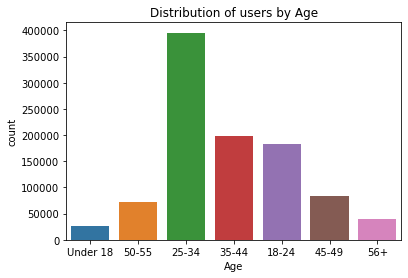

In [192]:
sns.countplot('Age',data=dff)
plt.title('Distribution of users by Age')

#### Even though we have found what is the age occupation of most number of users from users dataset, but we are not sure whether the people of same occupation has rated more number of movies. Hence doing this plot on merged Dataset

Text(0.5, 1.0, 'Distribution of users by Occupation')

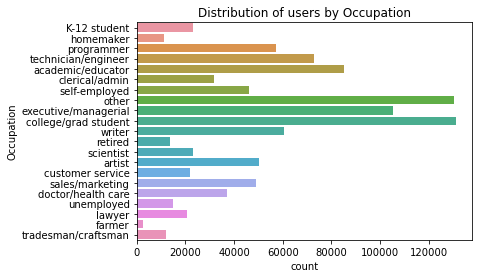

In [193]:
sns.countplot(y='Occupation',data=dff,orient="h")
plt.title('Distribution of users by Occupation')

### Grouping the data with respect to Movies to find high rated movies

In [133]:
temp1=dff.groupby(['MovieID','Title'])\
                            .agg(no_of_ratings=('Rating','size'),Avg_Rating=('Rating','mean'))\
                            .sort_values(by=['Avg_Rating'],ascending=False)\
                            .reset_index()
                       

In [134]:
temp1.loc[temp1['no_of_ratings']>100] 

,MovieID,Title,no_of_ratings,Avg_Rating
14,2019,Seven Samurai (The Magnificent Seven) (Shichin...,628,4.560510
15,318,"Shawshank Redemption, The",2227,4.554558
16,858,"Godfather, The",2223,4.524966
17,745,"Close Shave, A",657,4.520548
18,50,"Usual Suspects, The",1783,4.517106
...,...,...,...,...
3623,2555,Baby Geniuses,164,1.701220
3641,2383,Police Academy 6: City Under Siege,149,1.657718
3645,2817,Aces: Iron Eagle III,125,1.640000
3648,3593,Battlefield Earth,342,1.611111


<p>Just considering the cutoff that a movie should be rated by atleaset 100 users to be rated as a genuine rated film.
    Hence <b>Seven Samurai</b> is the high rated film in the data</p>

In [135]:
temp1.loc[temp1['no_of_ratings'] == max(temp1['no_of_ratings'])] 

,MovieID,Title,no_of_ratings,Avg_Rating
75,2858,American Beauty,3428,4.317386


<p>More number of users have given their rating for <b>American Beauty</b></p>

In [136]:
temp1.loc[(temp1['no_of_ratings']>100) & (temp1['Avg_Rating']>=4)] 

,MovieID,Title,no_of_ratings,Avg_Rating
14,2019,Seven Samurai (The Magnificent Seven) (Shichin...,628,4.560510
15,318,"Shawshank Redemption, The",2227,4.554558
16,858,"Godfather, The",2223,4.524966
17,745,"Close Shave, A",657,4.520548
18,50,"Usual Suspects, The",1783,4.517106
...,...,...,...,...
373,497,Much Ado About Nothing,667,4.000000
374,1827,"Big One, The",102,4.000000
382,2670,"Run Silent, Run Deep",220,4.000000
415,1238,Local Hero,351,4.000000


There are around 302 movies where the movies are considered good with rating above 4

In [137]:
temp2=dff.groupby(['UserID'])\
                            .agg(no_of_ratings=('Rating','size'),Avg_Rating=('Rating','mean'))\
                            .sort_values(by=['Avg_Rating'],ascending=False)\
                            .reset_index()

In [138]:
temp2

,UserID,no_of_ratings,Avg_Rating
0,283,27,4.962963
1,2339,23,4.956522
2,3324,21,4.904762
3,3902,165,4.890909
4,446,51,4.843137
...,...,...,...
6035,5850,58,1.844828
6036,4539,119,1.815126
6037,2744,138,1.304348
6038,4486,51,1.058824


In [139]:
temp2.loc[temp2['no_of_ratings']>10] 

,UserID,no_of_ratings,Avg_Rating
0,283,27,4.962963
1,2339,23,4.956522
2,3324,21,4.904762
3,3902,165,4.890909
4,446,51,4.843137
...,...,...,...
6035,5850,58,1.844828
6036,4539,119,1.815126
6037,2744,138,1.304348
6038,4486,51,1.058824


The user with ID <b>283</b> has given rated movies higher and the user with ID <b>3598</b> has rated most of the movies as low

In [140]:
temp2.loc[temp2['no_of_ratings'] == max(temp2['no_of_ratings'])] 

,UserID,no_of_ratings,Avg_Rating
4056,4169,2314,3.551858


The User with UserID <b>4169</b> has given ratings for more number of movies 

## Creating a Pivot Table

In [141]:
matrix = pd.pivot_table(dff,index="UserID",columns='Title',values='Rating')
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6040 entries, 1 to 999
Columns: 3664 entries, $1,000,000 Duck to eXistenZ
dtypes: float64(3664)
memory usage: 168.9+ MB


In [142]:
matrix.head(20)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,5.0
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [143]:
matrix.fillna(0,inplace=True)
matrix.head(10)

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,5.0
1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
matrix.columns

Index(['$1,000,000 Duck', ''Night Mother', ''Til There Was You', ''burbs, The',
       '...And Justice for All', '1-900', '10 Things I Hate About You',
       '101 Dalmatians', '12 Angry Men', '13th Warrior, The',
       ...
       'Young Poisoner's Handbook, The', 'Young Sherlock Holmes',
       'Young and Innocent', 'Your Friends and Neighbors', 'Zachariah',
       'Zed & Two Noughts, A', 'Zero Effect',
       'Zero Kelvin (Kjærlighetens kjøtere)', 'Zeus and Roxanne', 'eXistenZ'],
      dtype='object', name='Title', length=3664)

## Item Based Approach : Pearson Correlation

In [194]:
input_movie = input('Enter a Movie name:')
rating_movie = matrix[input_movie]
similar_rated_movies = matrix.corrwith(rating_movie)

Enter a Movie name:Liar Liar


In [195]:
similar_rated_movies

Title
$1,000,000 Duck                        0.063723
'Night Mother                          0.048226
'Til There Was You                     0.073924
'burbs, The                            0.225559
...And Justice for All                 0.074494
                                         ...   
Zed & Two Noughts, A                   0.014045
Zero Effect                            0.174860
Zero Kelvin (Kjærlighetens kjøtere)   -0.006114
Zeus and Roxanne                       0.067541
eXistenZ                               0.085360
Length: 3664, dtype: float64

In [196]:
df_similar = pd.DataFrame(similar_rated_movies,columns=['Correlation Value'])
df_similar.sort_values('Correlation Value',ascending=False,inplace=True)
df_similar.iloc[1:].head()

,Correlation Value
Title,
Mrs. Doubtfire,0.499927
Dumb & Dumber,0.459601
Ace Ventura: Pet Detective,0.458654
Home Alone,0.455967
"Wedding Singer, The",0.429222


## Item Based Approach : Cosine Similarity 

##### Item Similarity Matrix 

In [197]:
item_sim_matrix = cosine_similarity(matrix.T)
item_sim_matrix = pd.DataFrame(item_sim_matrix,index=matrix.columns,columns=matrix.columns)
item_sim_matrix.head()

Title,"$1,000,000 Duck",'Night Mother,'Til There Was You,"'burbs, The",...And Justice for All,1-900,10 Things I Hate About You,101 Dalmatians,12 Angry Men,"13th Warrior, The",...,"Young Poisoner's Handbook, The",Young Sherlock Holmes,Young and Innocent,Your Friends and Neighbors,Zachariah,"Zed & Two Noughts, A",Zero Effect,Zero Kelvin (Kjærlighetens kjøtere),Zeus and Roxanne,eXistenZ
Title,,,,,,,,,,,,,,,,,,,,,
"$1,000,000 Duck",1.000000,0.072357,0.037011,0.079291,0.060838,0.00000,0.058619,0.189843,0.094785,0.058418,...,0.038725,0.076474,0.000000,0.044074,0.0,0.045280,0.039395,0.000000,0.120242,0.027003
'Night Mother,0.072357,1.000000,0.115290,0.115545,0.159526,0.00000,0.076798,0.137135,0.111413,0.046135,...,0.053010,0.087828,0.063758,0.135962,0.0,0.091150,0.074787,0.000000,0.000000,0.077807
'Til There Was You,0.037011,0.115290,1.000000,0.098756,0.066301,0.08025,0.127895,0.128523,0.079115,0.066598,...,0.029200,0.062893,0.000000,0.079187,0.0,0.022594,0.079261,0.000000,0.047526,0.063284
"'burbs, The",0.079291,0.115545,0.098756,1.000000,0.143620,0.00000,0.192191,0.250140,0.170719,0.197808,...,0.113386,0.207897,0.019962,0.138064,0.0,0.055704,0.161174,0.000000,0.033567,0.110525
...And Justice for All,0.060838,0.159526,0.066301,0.143620,1.000000,0.00000,0.075093,0.178928,0.205486,0.122431,...,0.089998,0.153006,0.067009,0.109029,0.0,0.086080,0.110867,0.074317,0.000000,0.111040


##### User Similarity Matrix 

In [198]:
user_sim_matrix = cosine_similarity(matrix)
user_sim_matrix = pd.DataFrame(user_sim_matrix,index=matrix.index,columns= matrix.index)
user_sim_matrix.head()

UserID,1,10,100,1000,1001,1002,1003,1004,1005,1006,...,990,991,992,993,994,995,996,997,998,999
UserID,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.254736,0.123967,0.207800,0.139112,0.110320,0.121384,0.180073,0.103137,0.052816,...,0.079367,0.038048,0.032136,0.067631,0.070052,0.035731,0.170184,0.159267,0.119356,0.122391
10,0.254736,1.000000,0.259052,0.279838,0.158108,0.112659,0.141661,0.431184,0.193049,0.102253,...,0.154060,0.185809,0.083548,0.125607,0.118288,0.146217,0.304110,0.165321,0.133022,0.247883
100,0.123967,0.259052,1.000000,0.306067,0.075625,0.110450,0.358686,0.237292,0.171609,0.099147,...,0.098235,0.097953,0.065152,0.178664,0.271311,0.033754,0.344290,0.204302,0.113522,0.306937
1000,0.207800,0.279838,0.306067,1.000000,0.098971,0.047677,0.201722,0.355619,0.323584,0.130702,...,0.170100,0.076779,0.000000,0.200343,0.380741,0.044404,0.330748,0.172803,0.098456,0.250564
1001,0.139112,0.158108,0.075625,0.098971,1.000000,0.164611,0.053807,0.149848,0.137387,0.134512,...,0.146055,0.026852,0.096868,0.119433,0.092099,0.109539,0.221792,0.103104,0.269555,0.178137


### CSR matrix and Printing recommendations based on KNN 

In [199]:
csrmatrix = csr_matrix(matrix.T.values)
csrmatrix

<3664x6040 sparse matrix of type '<class 'numpy.float64'>'
	with 997085 stored elements in Compressed Sparse Row format>

In [200]:
from sklearn.neighbors import NearestNeighbors

In [201]:
knn = NearestNeighbors(n_neighbors=5,metric='cosine',n_jobs=-1)
knn.fit(csrmatrix)

NearestNeighbors(metric='cosine', n_jobs=-1)

In [202]:
query_movie = input('Enter a movie name:')
distances,indices = knn.kneighbors(matrix[query_movie].values.reshape(1,-1),n_neighbors=6)

for i in range(0,len(distances.flatten())):
    if(i==0):
        print('Recommendations for {0}: \n'.format(query_movie))
    else:
        print('{0}. {1}'.format(i,matrix.columns[indices.flatten()[i]]))

Enter a movie name:Liar Liar
Recommendations for Liar Liar: 

1. Mrs. Doubtfire
2. Ace Ventura: Pet Detective
3. Dumb & Dumber
4. Home Alone
5. Wayne's World


## Matrix Factorization

In [154]:
#pip install keras

In [155]:
#pip install tensorflow

In [156]:
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

In [174]:
u = dff.UserID.unique()
m = dff.MovieID.unique()

userid_to_idx = {o:i for i,o in enumerate(u)}
movieid_to_idx = {o:i for i,o in enumerate(m)}

In [175]:
dff['UserID'] = dff['UserID'].apply(lambda x: userid_to_idx[x])
dff['MovieID'] = dff['MovieID'].apply(lambda x: movieid_to_idx[x])
split = np.random.rand(len(dff)) < 0.8
train_val = dff[split]
test = dff[~split]
split1 = np.random.rand(len(train_val)) < 0.75
train = train_val[split1]
validation = train_val[~split1]

In [176]:
train.shape, validation.shape, test.shape

((599763, 12), (200276, 12), (200170, 12))

In [177]:
no_of_unique_movies = len(dff['MovieID'].unique())
no_of_unique_users = len(dff['UserID'].unique())

print(no_of_unique_movies,no_of_unique_users)

3706 6040


In [178]:
latent_factors = 64
user_input = Input(shape=(1,),name='User-input',dtype='int64')

In [179]:
user_embedding = Embedding(no_of_unique_users,latent_factors,name='user_embedding')(user_input)

In [180]:
user_vec=Flatten(name="Flatten-Users")(user_embedding)

In [181]:
movie_input = Input(shape=(1,), name="Movie-Input")
movie_embedding = Embedding(no_of_unique_movies, latent_factors, name="Movie-Embedding")(movie_input)
movie_vec = Flatten(name="Flatten-Movies")(movie_embedding)

In [182]:
import tensorflow as tf
import keras
sim =tf.keras.layers.dot([user_vec,movie_vec],name='Similarity-Dot-Product',axes=1)
model = keras.models.Model([user_input,movie_input],sim)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='mse')

In [183]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 User-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Movie-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 64)        386560      ['User-input[0][0]']             
                                                                                                  
 Movie-Embedding (Embedding)    (None, 1, 64)        237184      ['Movie-Input[0][0]']            
                                                                                            

In [184]:
model_hist = model.fit([train.UserID,train.MovieID],train.Rating,
                      batch_size=128,epochs=20,
                       validation_data = ([validation.UserID,validation.MovieID],validation.Rating),
                       verbose=1)

Epoch 1/20
4686/4686 [==============================] - 59s 12ms/step - loss: 14.0455 - val_loss: 13.9637
Epoch 2/20
4686/4686 [==============================] - 61s 13ms/step - loss: 12.4078 - val_loss: 9.7863
Epoch 3/20
4686/4686 [==============================] - 58s 12ms/step - loss: 6.4557 - val_loss: 3.9350
Epoch 4/20
4686/4686 [==============================] - 58s 12ms/step - loss: 2.7675 - val_loss: 2.0785
Epoch 5/20
4686/4686 [==============================] - 61s 13ms/step - loss: 1.6608 - val_loss: 1.4246
Epoch 6/20
4686/4686 [==============================] - 69s 15ms/step - loss: 1.2311 - val_loss: 1.1426
Epoch 7/20
4686/4686 [==============================] - 65s 14ms/step - loss: 1.0378 - val_loss: 1.0070
Epoch 8/20
4686/4686 [==============================] - 65s 14ms/step - loss: 0.9410 - val_loss: 0.9358
Epoch 9/20
4686/4686 [==============================] - 77s 16ms/step - loss: 0.8887 - val_loss: 0.8958
Epoch 10/20
4686/4686 [==============================] - 74s 

In [185]:
y_pred = model.predict([test.UserID,test.MovieID],verbose=0)

#### Calulating RMSE

In [189]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test.Rating,y_pred,squared=False)
print('Root mean squared error :{:.3f}'.format(rmse))

Root mean squared error :0.898


#### Calculating MAPE

In [190]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(test.Rating,y_pred)
print('Mean absolute Percentage error :{:.3f}'.format(mape))

Mean absolute Percentage error :0.275


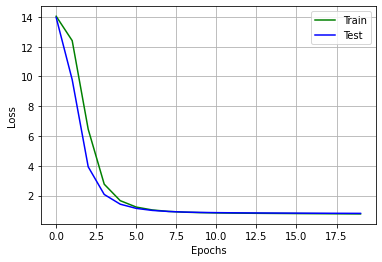

In [191]:
plt.plot(model_hist.history['loss'],'g')
plt.plot(model_hist.history['val_loss'],'b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Test'],loc='upper right')
plt.grid(True)
plt.show()